# Layer Analytics of Neural Networks


In [64]:
import os, sys, math, datetime
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model
# from mltk.utils.commander import query_platform

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Concatenate,
)
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths

In [65]:
models_dir = initialize()

In [66]:
model_name = "mobilenetv2_0.1_96_c1_o3_keras"
#model_name = "efficientNetB0_1_96_c1_o3_keras"

In [67]:
models_tf_path = f"i:/tinyml/tiny_cnn/models/{model_name}/{model_name}.h5"

In [68]:
# Configure pandas to show all columns & rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Helper Functions

In [69]:
# Helper functions


def flat_size(shape: list):
    out = 1
    for k in shape:
        out *= k

    return out

# Get the model

In [70]:
model = keras.models.load_model(models_tf_path)

In [71]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [72]:
summary = model.summary(expand_nested=True)

Model: "mobilenetv2_0.10_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 8)    72          ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 8)    32          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 8)    0           ['bn_Conv1[0][0]']               
                                                                                

In [73]:
mltk_summary = summarize_model(model)
print(mltk_summary)

Model: "mobilenetv2_0.10_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 8)    72          ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 8)    32          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 8)    0           ['bn_Conv1[0][0]']               
                                                                                

In [74]:
# MLTK profile model reads the mode from a path - only works for MLTK models!

# profiling_results = profile_model(models_tf_path, accelerator='MVP', build=True)

In [75]:
# Show model in local version of Netron.app
#view_model(model, tflite=True, build=True)

In [76]:
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [77]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv2_0.1_96_c1_o3_keras/mobilenetv2_0.1_96_c1_o3_keras_layers.pkl')

# Get details from the different layers of the model

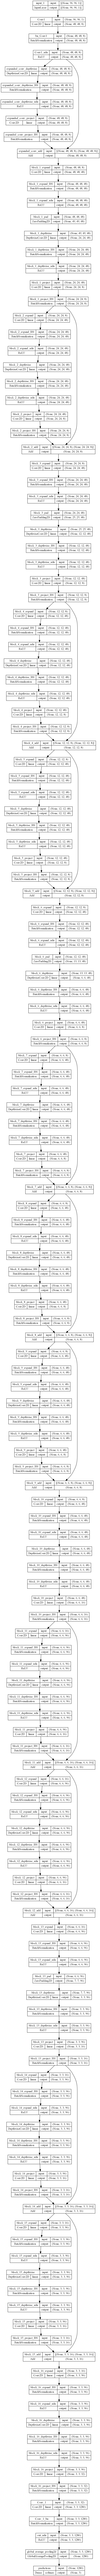

In [78]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Layer Metrics Helper Functions

In [79]:
def Conv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/conv.py
    """

    if isinstance(layer, keras.layers.Conv2D):
        _, _, _, in_depth = layer.input_shape  # layer.input_data.shape
        _, out_h, out_w, out_depth = layer.output_shape  # layer.output_data.shape
    else:
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    name = layer.name
    macs = w_h * w_w * in_depth * out_w * out_h * out_depth
    ops = macs * 2

    if layer.use_bias:
        ops += out_w * out_h * out_depth

    return (name, macs, ops)

In [80]:
def DepthwiseConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """

    # if isinstance(layer, TfliteDepthwiseConv2dLayer):
    #     _, _, _, in_depth = layer.input_data.shape
    #     _, out_h, out_w, out_depth = layer.output_data.shape

    # else: keras.layers.DepthwiseConv2D
    if isinstance(layer, keras.layers.DepthwiseConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    depth_multiplier = out_depth // in_depth

    name = layer.name
    macs = w_h * w_w * depth_multiplier * in_depth * out_w * out_h
    ops = macs * 2

    if layer.use_bias:
        ops += depth_multiplier * in_depth * out_w * out_h

    return (name, macs, ops)

In [81]:
def SeparableConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """
    name = layer.name
    if isinstance(layer, keras.layers.SeparableConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    else:
        return (name, "mac_error", "ops_error")

    w_h, w_w = layer.kernel_size

    macs_depth = w_h * w_w * in_depth * out_w * out_h
    macs_point = in_depth * out_w * out_h * out_depth
    macs = macs_depth + macs_point
    ops = macs * 2

    if layer.use_bias:
        ops += in_depth * out_w * out_h  # for depthwise convolution
        ops += (
            out_w * out_h * out_depth
        )  # for pointwise convolution ## TODO: check the calculations

    return (name, macs, ops)

In [82]:
def Dense_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/dense.py
    """

    if isinstance(layer, keras.layers.Dense):
        bias_ops = 0
        # if isinstance(layer, TfliteFullyConnectedLayer):
        #     in_depth = layer.input_data.shape[-1]
        #     out_depth = layer.output_data.shape[-1]
        #     if layer.use_bias:
        #         bias_ops = layer.outputs[0].shape.flat_size
        # else:
        in_depth = layer.input_shape[-1]
        out_depth = layer.output_shape[-1]
        if layer.use_bias:
            bias_ops = flat_size(layer.output_shape[1:])

        name = layer.name
        macs = in_depth * out_depth
        ops = macs * 2 + bias_ops

    return (name, macs, ops)

In [83]:
def AveragePooling2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/pooling.py
    """

    if isinstance(layer, keras.layers.AveragePooling2D):
        f_h, f_w = layer.pool_size
        name = layer.name
        # if isinstance(layer, KerasLayer):
        output_shape = layer.output_shape
        # else:
        #     output_shape = layer.outputs[0].shape

        ops = flat_size(output_shape[1:]) * (f_h * f_w + 1)  # + 1 for the division

    return (name, ops)

In [84]:
def calculate_no_activations(layer):
    if isinstance(
        layer, (keras.layers.Conv2D, keras.layers.Dense, keras.layers.DepthwiseConv2D)
    ):  # , )):keras.layers.Input
        # if isinstance(layer, (keras.layers.Conv2D)):
        # if isinstance(layer, (keras.layers.DepthwiseConv2D)):
        # if isinstance(layer, (keras.layers)):
        if layer.data_format == "channels_first":
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, out_h, out_w, out_depth = layer.output_shape

        return out_h * out_w * out_depth

    else:
        return 0

In [85]:
def print_layer_config(layer, layer_type):
    if isinstance(layer, layer_type):
        print(f"  Layer: {type(layer)}")
        print(layer.get_config())
        print()
    else:
        pass
    return layer.layer_config

In [93]:
def parse_layer_input(layer_input):
    """Parses the tf.model.layers.input and extracts the following node infos:
        - node_name(s) of all input nodes
        - node_type(s) of all input nodes

    Args:
        layer_input (tf.model.layers.input): _description_

    Returns:
        dict: Dictionary containing the extracted node input infos
    """
    input_dict = {}
    if type(layer_input) is list:
        for i, item in enumerate(layer_input):
            #print(f"Input_{i}: {item.__dict__['_name']}")
            node_name, node_type = item.__dict__['_name'].split("/")
            input_dict[f"input_node_{i}"] = node_name
            input_dict[f"input_node_type_{i}"] = node_type
    else:
        try:
            node_name, node_type = layer_input.__dict__['_name'].split("/")
            input_dict["input_node_1"] = node_name
            input_dict["input_node_type_1"] = node_type
        except:
            input_dict["input_node_1"] = layer_input.__dict__['_name']
    #print(input_dict)
    return input_dict

# Extract layer infos

In [96]:
def get_layer_list(model):
    layer_list = []
    for i, layer in enumerate(model.layers):
        layer_stats = {}
        layer_stats["index"] = i
        layer_stats["name"] = layer.name
        layer_stats["layer_type"] = type(layer)  # TODO: find a better representation
        layer_stats["input_shape"] = layer.input_shape

        layer_stats["input"] = layer.input

        layer_input_dict = parse_layer_input(layer.input)
        layer_stats |= layer_input_dict # new Python 3.9 dict merge operation 
        #layer_stats.update(layer_input_dict)

        layer_stats["output_shape"] = layer.output_shape
        layer_stats["dtype"] = layer.compute_dtype
        layer_stats["params"] = layer.count_params()
        layer_stats["variables"] = len(layer.variables)
        try:
            layer_stats["weights_shape"] = layer.weights[0].shape
            layer_stats["weights_name"] = layer.weights[0].name
            layer_stats["weights_dtype"] = layer.weights[0].dtype
            layer_stats["#_activations"] = calculate_no_activations(layer)

        except:
            layer_stats["weights_shape"] = 0
            layer_stats["weights_name"] = 0
            layer_stats["weights_dtype"] = 0
            layer_stats["#_activations"] = 0


        layer_config = layer.get_config()

        # Set default values for parameters that are not present in each layer
        layer_stats["OPS"] = 0
        layer_stats["MACS"] = 0
        layer_stats["filters"] = 0
        layer_stats["trainable"] = 0
        layer_stats["kernel_size"] = 0
        layer_stats["strides"] = 0
        layer_stats["padding"] = 0
        layer_stats["dilation_rate"] = 0
        layer_stats["groups"] = 0
        layer_stats["activation"] = 0
        layer_stats["use_bias"] = 0
        layer_stats["data_format"] = 0

        # if isinstance(layer, keras.layers.InputLayer):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        if isinstance(layer, keras.layers.Conv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()
            name, macs, ops = Conv2D_MACs(layer)

            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            # layer_stats["# activation"] = layer.output_shape[1]
            layer_stats["filters"] = layer_config["filters"]
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        if isinstance(layer, keras.layers.DepthwiseConv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()

            name, macs, ops = DepthwiseConv2D_MACs(layer)

            # layer_stats["filters"]= layer_config["filters"]  # TODO: key error -> refactor with Conv2D
            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        # if isinstance(layer, keras.layers.Dense):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        # if isinstance(layer, keras.layers.BatchNormalization ):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()
        layer_list.append(layer_stats)
    return layer_list

In [97]:
layer_list = get_layer_list(model)
layer_stats_df = pd.DataFrame.from_dict(layer_list)
layer_stats_df.head(10)

,index,name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format,input_node_type_1,input_node_0,input_node_type_0
0,0,input_1,<class 'keras.engine.input_layer.InputLayer'>,"[(None, 96, 96, 1)]","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"[(None, 96, 96, 1)]",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Conv1,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 96, 96, 1)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 48, 48, 8)",float32,72,1,"(3, 3, 1, 8)",Conv1/kernel:0,<dtype: 'float32'>,18432,331776,165888,8,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
2,2,bn_Conv1,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",Conv1,"(None, 48, 48, 8)",float32,32,4,(8),bn_Conv1/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0,Conv2D:0,NaN,NaN
3,3,Conv1_relu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",bn_Conv1,"(None, 48, 48, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FusedBatchNormV3:0,NaN,NaN
4,4,expanded_conv_depthwise,<class 'keras.layers.convolutional.depthwise_c...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",Conv1_relu,"(None, 48, 48, 8)",float32,72,1,"(3, 3, 8, 1)",expanded_conv_depthwise/depthwise_kernel:0,<dtype: 'float32'>,18432,331776,165888,0,True,"(3, 3)","(1, 1)",same,"(1, 1)",1,linear,False,channels_last,Relu6:0,NaN,NaN
5,5,expanded_conv_depthwise_BN,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",expanded_conv_depthwise,"(None, 48, 48, 8)",float32,32,4,(8),expanded_conv_depthwise_BN/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0,depthwise:0,NaN,NaN
6,6,expanded_conv_depthwise_relu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",expanded_conv_depthwise_BN,"(None, 48, 48, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FusedBatchNormV3:0,NaN,NaN
7,7,expanded_conv_project,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",expanded_conv_depthwise_relu,"(None, 48, 48, 8)",float32,64,1,"(1, 1, 8, 8)",expanded_conv_project/kernel:0,<dtype: 'float32'>,18432,294912,147456,8,True,"(1, 1)","(1, 1)",same,"(1, 1)",1,linear,False,channels_last,Relu6:0,NaN,NaN
8,8,expanded_conv_project_BN,<class 'keras.layers.normalization.batch_norma...,"(None, 48, 48, 8)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",expanded_conv_project,"(None, 48, 48, 8)",float32,32,4,(8),expanded_conv_project_BN/gamma:0,<dtype: 'float32'>,0,0,0,0,0,0,0,0,0,0,0,0,0,Conv2D:0,NaN,NaN
9,9,expanded_conv_add,<class 'keras.layers.merging.add.Add'>,"[(None, 48, 48, 8), (None, 48, 48, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...",expanded_conv_project_BN,"(None, 48, 48, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FusedBatchNormV3:0,Conv1_relu,Relu6:0


# Check for errors

In [ ]:
layer_stats_df[layer_stats_df["OPS"]=="ops_error"]

,index,name,layer_type,input_shape,input,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format


In [ ]:
layer_stats_df["layer_type"].unique()

array([<class 'keras.engine.input_layer.InputLayer'>,
       <class 'keras.layers.convolutional.conv2d.Conv2D'>,
       <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>,
       <class 'keras.layers.activation.relu.ReLU'>,
       <class 'keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>,
       <class 'keras.layers.merging.add.Add'>,
       <class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>,
       <class 'keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>,
       <class 'keras.layers.core.dense.Dense'>], dtype=object)

# Save layer dataframe

In [ ]:
layer_stats_df.to_pickle(models_layer_df_path)

In [ ]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv2_0.1_96_c1_o3_keras/mobilenetv2_0.1_96_c1_o3_keras_layers.pkl')

In [ ]:
#tf.lite.experimental.Analyzer.analyze(model_path='model.tflite')

# Code snippets reserved for trouble shooting

In [ ]:
#layer_stats_df[layer_stats_df["name"]=="block_2_compress_bn"]

,index,name,layer_type,input_shape,input,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format


In [ ]:
#layer_stats_df[layer_stats_df["name"].str.contains("add")]

,index,name,layer_type,input_shape,input,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format
9,9,expanded_conv_add,<class 'keras.layers.merging.add.Add'>,"[(None, 48, 48, 8), (None, 48, 48, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 48, 48, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,27,block_2_add,<class 'keras.layers.merging.add.Add'>,"[(None, 24, 24, 8), (None, 24, 24, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 24, 24, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,45,block_4_add,<class 'keras.layers.merging.add.Add'>,"[(None, 12, 12, 8), (None, 12, 12, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 12, 12, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,54,block_5_add,<class 'keras.layers.merging.add.Add'>,"[(None, 12, 12, 8), (None, 12, 12, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 12, 12, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72,72,block_7_add,<class 'keras.layers.merging.add.Add'>,"[(None, 6, 6, 8), (None, 6, 6, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 6, 6, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81,81,block_8_add,<class 'keras.layers.merging.add.Add'>,"[(None, 6, 6, 8), (None, 6, 6, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 6, 6, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90,90,block_9_add,<class 'keras.layers.merging.add.Add'>,"[(None, 6, 6, 8), (None, 6, 6, 8)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 6, 6, 8)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,107,block_11_add,<class 'keras.layers.merging.add.Add'>,"[(None, 6, 6, 16), (None, 6, 6, 16)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 6, 6, 16)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116,116,block_12_add,<class 'keras.layers.merging.add.Add'>,"[(None, 6, 6, 16), (None, 6, 6, 16)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 6, 6, 16)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
134,134,block_14_add,<class 'keras.layers.merging.add.Add'>,"[(None, 3, 3, 16), (None, 3, 3, 16)]","[KerasTensor(type_spec=TensorSpec(shape=(None,...","(None, 3, 3, 16)",float32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Getting infos about Input Nodes

In [ ]:
model.layers[0].get_config()

{'batch_input_shape': (None, 96, 96, 1),
 'dtype': 'float32',
 'sparse': False,
 'ragged': False,
 'name': 'input_1'}

In [ ]:
# i = 134
# l_inputs = model.layers[i].input
# type(l_inputs)

list

In [92]:
for i in range(len(model.layers)):  
    parse_layer_input(model.layers[i].input)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#model.layers[134].input[0].__dict__

{'_type_spec': TensorSpec(shape=(None, 3, 3, 16), dtype=tf.float32, name=None),
 '_inferred_value': None,
 '_name': 'block_13_project_BN/FusedBatchNormV3:0',
 '_keras_history': KerasHistory(layer=<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F3606BB970>, node_index=0, tensor_index=0)}